# Draw Primitive H-R Diagram

You will now learn what photometry can show you. The first trial is to draw the H-R diagram! (Benefited from [Jason Shilling Kendall](http://www.jasonkendall.com/WPU/HRDiagram/))

You may have seen this on textbooks, but now we will draw primitive H-R diagram from WFPC2 F450W and F814W filters of Hubble Space Telescope (HST) archieved data.

## Download Data
First, go to [this link](http://hla.stsci.edu/). Click on the "Enter Site Here", and search for "M80". You will see a lot of results. Type "11233" to the "PropID" column, "WFPC2" to "Detector" column, and hit Enter. 

Find the data with "NExposures" = 6 and "VisitNum" = 6. There should be only two data.

At the last part of the columns, you will see "DAOCat", which is the primitive photometry results using DAOPHOT algorithm. "SEXCat" is the one used SExtractor algorithm. We will use "DAOCat": click on the "DAOphot" links of the two images. The catalogs will be added to your "cart". Above the table, you have "Cart" tab. Go there and download the data. I have saved the data with name "F450W.dat" and "F814W.dat", respectively.


## Play with Image
From the STScI website, you can play with image by the tools they provide. For the corresponding images, click on the "Display" and "PlotCat" links. You will intuitively know what each buttons on the pop-up window are. Play with it!

* **Question**: Go to "PlotCat" and check on DAOphot and SExtractor. Why do you think the results differ?
 * Hint: Click on the "?Help" icon on the top-right part of the pop up window.
 * Hint: Why did they implement both, not one of them?
 
* **Question**: The target is a globular cluster. Why do you think it doesn't look like a GC? Why did people took the image like this?

## Drawing H-R Diagram

If you've downloaded the data, go to the directory and make a script to plot a H-R diagram. For my case, I did it like this:


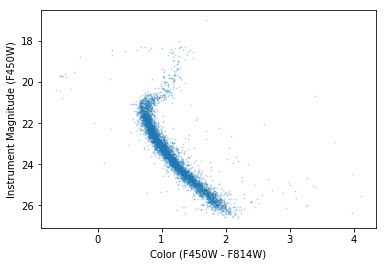

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
F450 = np.loadtxt('HST_Tutorial/F450W.dat') # NumPy automatically skips the commented rows.
F814 = np.loadtxt('HST_Tutorial/F814W.dat')

mask  = np.zeros(len(F450)).astype(bool)
color = np.zeros(len(F450))


# Get color indices of the "same" stars in two filter images
for i in range(0, len(F450)):
    ID450 = F450[i,4]
    for j in range(0, len(F814)):
        ID814 = F814[j,4]
        if ID450 == ID814:
            mask[i]  = True
            color[i] = F450[i,5] - F814[j,5]
            break # Once the matched item is found from F814, go to next star of F450.

# Plot and show
plt.plot(color[mask], F450[mask,5], 'o', ms=1, alpha=0.2)
plt.xlabel('Color (F450W - F814W)')
plt.ylabel('Instrument Magnitude (F450W)')
plt.gca().invert_yaxis()
plt.show()

In the example, I used `mask` array to select only the stars in F450 which have counterpart in F814.

* **Question**: What do you think the abscissa and ordinate mean?
* **Question**: Why could I generate such a good-looking H-R diagram? 
 * Hint: If you do the same thing for ground-based observation data, you may get uglier result.
* **Question**: For F450W data, the following is the plot showing magnitude and error. Why do you think this shape appears?
 * Hint: Msky and Stdev of the original file means the estimated sky and sky standard deviation values. Flux is of course the flux of the star in certain unit. With this knowledge, refer to [STScI IRAF PHOT manual](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?phot), the section "OUTPUT".
 

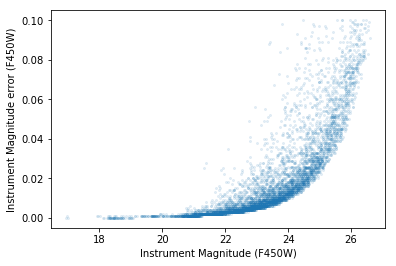

In [2]:
plt.plot(F450[:,5], F450[:,6], 'o', ms=2, alpha=0.1)
plt.xlabel('Instrument Magnitude (F450W)')
plt.ylabel('Instrument Magnitude error (F450W)')
plt.show()

# Elliptical Galaxy

As a second example, I will show you how to quantitatively describe an elliptical galaxy using imaging mode data.


## Download Data
At the same site as above, search for M87. Type "hst_11216_51_wfpc2_f606w_pc" to the "Dataset" column. Only one image will show up. This time, click on "FITS" in the "Retrieve" column. Download it. I saved it as "M87.fits".

## Play with Image
First of all, HST FITS image has extension! If you do not know what this means, see pp.20-21 of [this document][01]. So to see the images, use

    ginga M87.fits[1] M87.fits[2] M87.fits[3] &

The image [0] is called the "primary", and it contains the header information only. It doesn't have image data. [1] is the actual image we may be interested in, and named as "SCI". [2] and [3] are the weight and context images, named "WHT" and "CTX". For the detailed explanation for these images, refer to the section 5.4.6.3. of [this document][02]. These are kind of a byproduct after [drizzle][03] image reduction.

[01]: http://www.stsci.edu/hst/HST_overview/documents/datahandbook/hstdh_intro.pdf
[02]: http://www.stsci.edu/hst/HST_overview/documents/multidrizzle/ch55.html
[03]: https://en.wikipedia.org/wiki/Drizzle_(image_processing)

The following is an example of doing `pick` on `ginga`, and you can see that the object has quite circular shape from the FWHM fitting. 

<img src='HST_Tutorial/M87_ginga.png' width=800>

* **Question** What is the bar-like feature near the elliptical galaxy? Do you think it is going in to? Or is i out from the galaxy?
* **Question** Why do you think the image is slightly "rotated" by default?
 * Hint: look at the top-left panel (small image) of the screenshot

## Analyze
Now I want to load the image in Python for analysis. First I will print the information of the FITS file, and fit the 2-D Gaussian.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

hduList = fits.open('HST_Tutorial/M87.fits')
hduList.info()
# 0 (primary) : The primary header. No data included.
# 1 (SCI)     : Science image, i.e., real data.
# 2 (WHT)     : The weight image
# 3 (CTX)     : The context image

print('Let me fit 2-D Gaussian to the galaxy...')
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.centroids import centroid_2dg

# Save the image after cropping 100-pixel bezel.
image        = (hduList[1].data)[100:-100, 100:-100]

# Primitive sky subtraction by median
image       -= np.median(image)

# Setup coordinate grid
naxis        = image.shape[0]
y_fit, x_fit = np.mgrid[:naxis, :naxis]

# Find the center of mass of the cropped image
x_com, y_com = centroid_2dg(image)
print('Image center of mass: (x_0, y_0) = ({0:.3f}, {1:.3f})'.format(x_com, y_com))
print('='*80)

# Fit the Gaussian
fitter   = LevMarLSQFitter()
fit_init = Gaussian2D(amplitude=image.max(), x_mean=x_com, y_mean=y_com)
fitted   = fitter(fit_init, x_fit, y_fit, image)
x_std    = np.abs(fitted.x_stddev.value)
y_std    = np.abs(fitted.y_stddev.value)
print(fitted)

print('='*80)
print('FWHM in x and y: {0:.3f} {1:.3f}'.format(2.3548*x_std, 2.3548*y_std))
print('Keep in mind that the x, y above do not necessarily match with imageXY.')

ellip    = 1 - np.min((x_std, y_std))/np.max((x_std, y_std))
E_value  = (np.around(ellip*10)).astype(int)
print('='*80)
print('Ellipticity = {0:.3f}, so E{1} galaxy in Hubble sequence.'.format(ellip, E_value))

Filename: HST_Tutorial/M87.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     426   ()      
  1  SCI         ImageHDU       110   (850, 850)   float32   
  2  WHT         ImageHDU       130   (850, 850)   float32   
  3  CTX         ImageHDU       129   (850, 850)   int32   
Let me fit 2-D Gaussian to the galaxy...
Image center of mass: (x_0, y_0) = (150.653, 232.136)
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      amplitude       x_mean        y_mean    ...    y_stddev        theta     
    ------------- ------------- ------------- ... -------------- --------------
    96.9807266073 146.209271873 229.502494006 ... -2.07538640088 -142.383357934
FWHM in x and y: 4.119 4.887
Keep in mind that the x, y above do not necessarily match with imageXY.
Ellipticity = 0.157, so E2 galaxy in Hubble sequence.


* **Question**: Why do you think I cropped the image with 100 pixel bezel?
* **Question**: Why do you think I calculated the center of mass of the image?
* **Question**: How do you think about the sky subtraction? Do you think it is reliable? And do you think the result is reliable?
* **Question**: Why do you think I wrote "`Keep in mind that the x, y above do not necessarily match with imageXY.`"?
* **Question**: Why did I multiplied 2.3548 to x and y stddev?

